# [Kaggle - Plant Pathology 2020 - FGVC7](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)

### Imports

In [1]:
from fastai2.vision.all import *
import sklearn.metrics as skm
from sklearn.model_selection import StratifiedShuffleSplit

path = Path('/home/ec2-user/.fastai/data/plant-pathology')

### Checking training data

In [2]:
(path/'images').ls()

(#3642) [Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_654.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_959.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_555.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_634.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_1216.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_1296.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_1560.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Train_1304.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Train_670.jpg'),Path('/home/ec2-user/.fastai/data/plant-pathology/images/Test_285.jpg')...]

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


(1365, 2048)


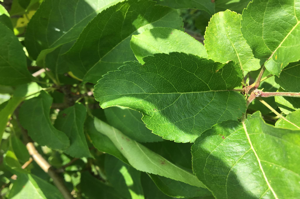

In [5]:
im = PILImage.create(path/'images'/f'{df.image_id.sample().values[0]}.jpg')
print(im.shape)
im.to_thumb(300)

##### Is this a multi-class multi-label or just multi-class? ...

In [6]:
cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

for c in cols:
    print(c, df.loc[df[c]==1, [col for col in cols if col!=c]].sum().sum())

healthy 0
multiple_diseases 0
rust 0
scab 0


##### ... It seems to be just multi-class

In [7]:
df['target'] = np.array(cols)[np.argmax(df[cols].values, axis=1)]
df.head()

,image_id,healthy,multiple_diseases,rust,scab,target
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


### Splitting training data in 3 folds and re-sampling minority class `multiple_diseases`

In [8]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
aug_df = pd.DataFrame()

for i, (train_index, test_index) in enumerate(sss.split(df, df.target)):
    df_split = df.copy()
    df_split['fold'] = i
    df_split.loc[train_index, 'which'] = 'train'
    df_split.loc[test_index, 'which'] = 'valid'
    X_train = df_split.loc[train_index]
    X_valid = df_split.loc[test_index]
    X_train.loc[:, 'which'] = 'train'
    X_valid.loc[:, 'which'] = 'valid'
    
    mult_dis = X_train.loc[X_train.target=='multiple_diseases']
    for _ in range(3): X_train = X_train.append(mult_dis)
    
    aug_df = aug_df.append(X_train).append(X_valid)
    
    print(i, aug_df.shape, [(X_train[c].sum()/len(X_train), X_train[c].sum()) for c in cols])
    
aug_df = aug_df.reset_index()

0 (2013, 8) [(0.24624829467939974, 361), (0.17462482946793997, 256), (0.2967257844474761, 435), (0.28240109140518416, 414)]
1 (4026, 8) [(0.24624829467939974, 361), (0.17462482946793997, 256), (0.2967257844474761, 435), (0.28240109140518416, 414)]
2 (6039, 8) [(0.24624829467939974, 361), (0.17462482946793997, 256), (0.2967257844474761, 435), (0.28240109140518416, 414)]


In [9]:
aug_df.head()

,index,image_id,healthy,multiple_diseases,rust,scab,target,fold,which
0,698,Train_698,0,0,0,1,scab,0,train
1,1260,Train_1260,0,0,1,0,rust,0,train
2,112,Train_112,0,0,0,1,scab,0,train
3,1411,Train_1411,0,0,0,1,scab,0,train
4,63,Train_63,1,0,0,0,healthy,0,train


### Helper functions

In [18]:
def get_x(r): return path/'images'/f"{r['image_id']}.jpg"
def get_y(r): return r['target']

def get_dls(bs, size, fold, df):
    df_fold = df.copy()
    df_fold = df_fold.loc[df_fold.fold==fold].reset_index()
    
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = get_x, 
                   get_y = get_y,
                   splitter=IndexSplitter(df_fold.loc[df_fold.which=='valid'].index),
                   item_tfms=Resize(700),
                   batch_tfms=aug_transforms(size=size, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True))
    dls = dblock.dataloaders(df_fold, bs=bs)
    assert (len(dls.train_ds) + len(dls.valid_ds)) == len(df_fold)
    return dls

class ColumnWiseRocAuc(Callback):
    def begin_epoch(self):
        self.targets, self.probas, self.y_true = Tensor([]), Tensor([]), LongTensor([])   
    
    def after_batch(self): 
        if not self.training:
            preds = F.softmax(self.pred, dim=1).detach().cpu()
            y = self.y[:, None].cpu()
            y_onehot = torch.FloatTensor(len(y), self.dls.c)
            y_onehot.zero_()
            y_onehot.scatter_(1, y, 1)

            self.probas = torch.cat((self.probas, preds))
            self.targets = torch.cat((self.targets, y_onehot))
            self.y_true = torch.cat((self.y_true, self.y.cpu()))
            print("Valid ", self.y_true.shape, self.training)
    
    def after_epoch(self):
        auc = 0.0
        for i in range(self.dls.c): auc += skm.roc_auc_score(self.targets[:, i], self.probas[:, i])
        print(f"column-wise avg AUC: {auc/self.dls.c}")
        print(f"column-wise sklearn avg AUC: {skm.roc_auc_score(self.targets, self.probas)}")
        print(f"column-wise sklearn avg AUC ovr: {skm.roc_auc_score(self.y_true, self.probas, multi_class='ovr')}")
        
def _accumulate(self, learn):
    pred = learn.pred
    if self.sigmoid: pred = torch.nn.functional.softmax(pred, dim=1) #hack for roc_auc_score
    if self.thresh:  pred = (pred >= self.thresh)
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    if self.flatten: pred,targ = flatten_check(pred,targ)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def RocAuc(axis=-1, average='macro', sample_weight=None, max_fpr=None,multi_class='ovr'):
    "Area Under the Receiver Operating Characteristic Curve for single-label binary classification problems"
    return skm_to_fastai(skm.roc_auc_score, axis=axis,
                         average=average, sample_weight=sample_weight, max_fpr=max_fpr,
                         flatten=False,multi_class=multi_class,sigmoid=True)
              
def get_learner(dls,arch,loss_func): return cnn_learner(dls,arch,loss_func=loss_func,metrics=[accuracy, RocAuc()])#.to_fp16()

def train_learner(learn, base_lr):
    learn.freeze()
    learn.fit_one_cycle(2, base_lr)
    
    learn.freeze_to(-3)
    learn.fit_one_cycle(2, slice(base_lr/(2.6**4),base_lr))
    
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(base_lr/(2.6**4),base_lr))
    
    return learn

def train_on_folds(bs, size, base_lr, folds):
    learners = []
    all_val_preds = []
    all_val_labels = []
    all_test_preds = []
    
    for fold in range(folds):
        print(f'\nProcessing fold: {fold}....')
        dls = get_dls(bs=bs, size=size, fold=fold, df=aug_df)
        
        learn = get_learner(dls, ARCH, LOSS_FUNC)
        learn = train_learner(learn, base_lr)
        learn.save(f'model_fold_{fold}')
        learners.append(learn)
        learn.recorder.plot_loss()
        
        test_dl = dls.test_dl(TEST_DF)
        test_preds, _ = learn.tta(dl=test_dl)
        val_preds, val_labels = learn.get_preds()
    
        all_val_preds.append(val_preds)
        all_val_labels.append(val_labels)
        all_test_preds.append(test_preds)
    
    plt.show()
    return learners, all_val_preds, all_val_labels, all_test_preds

### Exploring dataset and dataloader

In [11]:
dls = get_dls(bs=64, size=128, fold=2, df=aug_df)

In [12]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [13]:
dls.vocab

(#4) ['healthy','multiple_diseases','rust','scab']

In [16]:
df_fold = aug_df.loc[aug_df.fold==0].reset_index()
plants = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = get_x, 
                   get_y = get_y,
                   splitter=IndexSplitter(df_fold.loc[df_fold.which=='valid'].index),
                   item_tfms=Resize(700),
                   batch_tfms=aug_transforms(size=128, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True))

plants.summary(df_fold)

Setting-up type transforms pipelines
0           0    698   Train_698        0                  0     0     1   
1           1   1260  Train_1260        0                  0     1     0   
2           2    112   Train_112        0                  0     0     1   
3           3   1411  Train_1411        0                  0     0     1   
4           4     63    Train_63        1                  0     0     0   
5           5   1157  Train_1157        0                  0     0     1   
6           6   1242  Train_1242        0                  0     0     1   
7           7   1373  Train_1373        0                  0     1     0   
8           8   1365  Train_1365        0                  0     1     0   
9           9   1204  Train_1204        0                  0     1     0   
10         10   1636  Train_1636        0                  0     0     1   
11         11   1360  Train_1360        0                  0     0     1   
12         12    974   Train_974        0          


Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=2048x1365, TensorCategory(3))
    applying Resize gives
      (PILImage mode=RGB size=700x700, TensorCategory(3))
    applying ToTensor gives
      (TensorImage of size 3x700x700, TensorCategory(3))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm
    starting from
      (TensorImage of size 4x3x700x700, TensorCategory([3, 2, 3, 3], device='cuda:0'))
    applying IntToFloatTensor gives
      (TensorImage of size 4x3x700x700, TensorCategory([3, 2, 3, 3], device='cuda:0'))
    applying AffineCoordTfm gives
      (TensorImage of size 4x3x700x700, TensorCategory([3, 2, 3, 3], device='cuda:0'))
    applying RandomResizedCropGPU gives
      (TensorImage of size 4x3x128x128, TensorCategory([

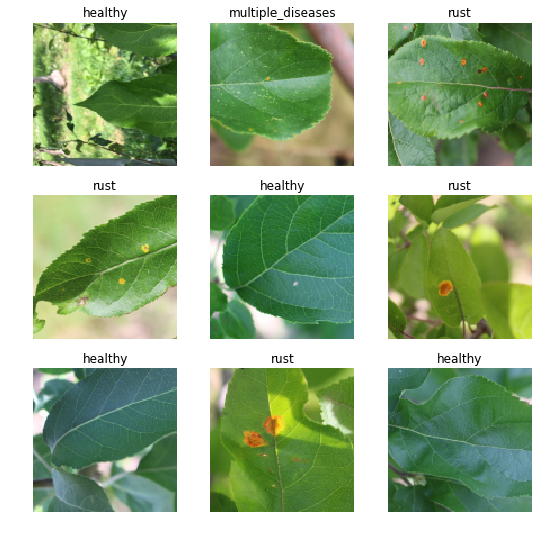

In [17]:
dls.show_batch()

## Modelling pipeline

### Finding best learning rate

In [20]:
ARCH = resnet34
LOSS_FUNC = None 
#LOSS_FUNC = LabelSmoothingCrossEntropy()
TEST_DF = pd.read_csv(path/'test.csv')
BS = 128
SIZE = 224

In [22]:
dls = get_dls(bs=BS, size=SIZE, fold=0, df=aug_df)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.002511886414140463)

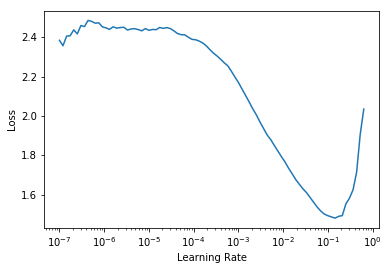

In [23]:
learn = cnn_learner(dls, ARCH, loss_func=LOSS_FUNC)
learn.lr_find()

### Training 3 models on the 3 folds (+ TTA) to perform ensembling later on


Processing fold: 0....


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.567328,0.673049,0.798903,0.924689,01:03
1,1.147105,0.475424,0.864717,0.953030,01:03


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.713205,0.449161,0.904936,0.962181,01:03
1,0.572976,0.243388,0.936015,0.980787,01:04


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.344381,0.315352,0.917733,0.980747,01:04
1,0.375307,0.522791,0.899452,0.951616,01:05
2,0.355925,0.266629,0.936015,0.975448,01:05
3,0.311574,0.192485,0.937843,0.983520,01:06
4,0.254276,0.174824,0.945155,0.983365,01:04



Processing fold: 1....


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.371307,0.597178,0.820841,0.928203,01:02
1,1.034148,0.468490,0.866545,0.948215,01:03


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.678628,0.508023,0.893967,0.942102,01:05
1,0.544183,0.458872,0.888483,0.960570,01:04


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.351364,0.360182,0.906764,0.967606,01:05
1,0.353166,0.545742,0.928702,0.959118,01:03
2,0.342516,0.407223,0.925046,0.948819,01:04
3,0.291318,0.261531,0.926874,0.973062,01:05
4,0.251548,0.260836,0.925046,0.973506,01:03



Processing fold: 2....


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.498841,1.151914,0.683729,0.917513,01:02
1,1.050189,0.442161,0.855576,0.958908,01:02


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.589164,1.448444,0.669104,0.910504,01:04
1,0.526192,0.422288,0.884826,0.967416,01:04


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.317655,0.695625,0.837294,0.946551,01:04
1,0.318853,0.579548,0.884826,0.950617,01:06
2,0.316908,0.370275,0.930530,0.969164,01:03
3,0.287748,0.249731,0.930530,0.976706,01:04
4,0.245286,0.204158,0.941499,0.979031,01:05


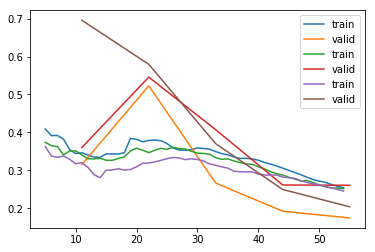

In [23]:
base_lr = 3e-3
learners, all_val_preds, all_val_labels, all_test_preds = train_on_folds(BS, SIZE, base_lr, folds=3)

In [24]:
[skm.roc_auc_score(el[0], el[1], multi_class='ovr') for el in zip(all_val_labels, all_val_preds)]

[0.9833651208539587, 0.9735060624348205, 0.9790305579938784]

## Exploring  one of the 3 trained `Learner` objects

In [22]:
resizing_learn = get_learner(dls, ARCH, LOSS_FUNC)
resizing_learn = resizing_learn.load('model_fold_0')

### Checking if we manage to increase performance with progressive resizing

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=1.5848931980144698e-06)

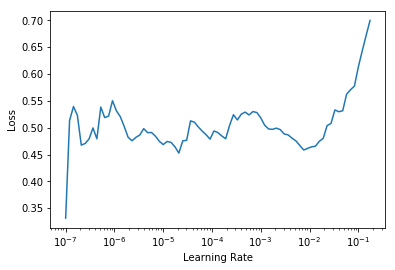

In [38]:
resizing_learn.dls = get_dls(32, 512, 0, aug_df)
resizing_learn.lr_find()

In [39]:
resizing_learn.fine_tune(base_lr=3e-3, epochs=4, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.447707,0.219964,0.912249,0.982968,01:16
1,0.415317,0.205527,0.928702,0.980426,01:15


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.302864,0.205725,0.925046,0.982114,01:35
1,0.343296,0.163994,0.941499,0.989620,01:34
2,0.251546,0.147377,0.946984,0.987823,01:34
3,0.179311,0.143373,0.956124,0.989966,01:34


### Confusion matrix + checking what model gets wrong the most

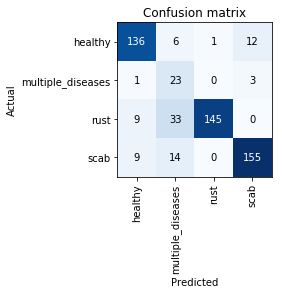

In [23]:
interp = ClassificationInterpretation.from_learner(resizing_learn)
interp.plot_confusion_matrix()

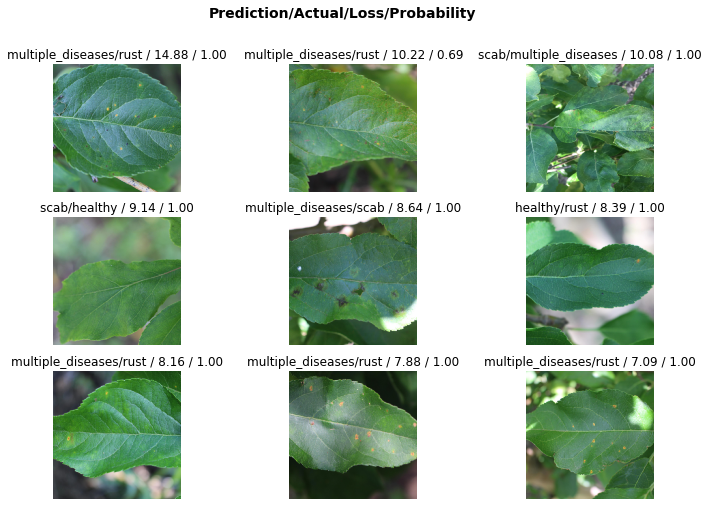

In [24]:
interp.plot_top_losses(9, nrows=3, figsize=(12,8))

### Test Time Augmentation (TTA)

In [27]:
preds,targs = learners[0].tta()
skm.roc_auc_score(targs, preds, multi_class='ovr')

0.9836254563618161

### Creating file for Kaggle submission

In [28]:
kaggle = pd.concat([TEST_DF, pd.DataFrame(np.mean(np.stack(all_test_preds), axis=0), columns=cols)], axis=1)

In [29]:
kaggle.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001233,0.141864,8.565698e-01,3.333769e-04
1,Test_1,0.000002,0.005450,9.945478e-01,2.195304e-07
2,Test_2,0.000002,0.000003,1.836379e-10,9.999951e-01
3,Test_3,0.999490,0.000003,1.013773e-04,4.053816e-04
4,Test_4,0.000008,0.121500,8.784904e-01,1.561672e-06


In [30]:
from IPython.display import FileLink, FileLinks

kaggle.to_csv('kaggle.csv', index=False)
FileLink('kaggle.csv')

/home/ec2-user/SageMaker/course-v4/nbs/kaggle.csv